In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing as mp
from matplotlib import animation

## Numerical Solver 

In [45]:
"""
Numerical solver for time-stepping method, default x range: [0, 1], y range: [0, 1] default t range: [0, 10]
Boundary conditions: c(x, y = 1; t) = 1 and c(x, y = 0; t) = 0; c(x = 0, y; t) = c(x = 1, y; t), initial
conditions: c(x, y; t = 0) = 0 for 0 ≤ x ≤ 1, 0 ≤ y < 1.
"""

N = 50
mesh_x = np.linspace(0, 1, 50)

# create empty matrix to store solution of PDE
c_0 = np.zeros((N, N))
c_0[:, -1].fill(1)
print(np.shape(c_0))

(50, 50)


### Jacobi iteration

In [46]:

def Jacobi_solver(n_i, c_):

    c = np.copy(c_)

    for j in range(n_i-2):
        j += 1
        for i in range(n_i):

            # boundary conditions
            if i == 0:
                c_ = 1/4 * (c[i+1, j] + c[-1, j] + c[i, j+1] + c[i, j-1])
            elif i == n_i-1:
                c_ = 1/4 * (c[1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
                
            else:
                c_ = 1/4 * (c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])

            c[i, j] = c_

    return c

### Gauss-Seidel iteration

In [47]:

# Take the grid point i, j and the matrix for current iteration and last iteration as input
def Gauss_Seidel_solver(i, j, n_i, c_k, c_k_1):

    # boundary conditions
    if i == 0:
        c_new = 1/4 * (c_k[i+1, j] + c_k_1[-1, j] + c_k[i, j+1] + c_k_1[i, j-1])
    elif i == n_i-1:
        c_new = 1/4 * (c_k[0, j] + c_k_1[i-1, j] + c_k[i, j+1] + c_k_1[i, j-1])
        
    else:
        c_new = 1/4 * (c_k[i+1, j] + c_k_1[i-1, j] + c_k[i, j+1] + c_k_1[i, j-1])

    return c_new

### Successive Over Relaxation

In [49]:
def SOR_solver(i, j, n_i, c_k, c_k_1, w=1.8):

    # boundary conditions
    if i == 0:
        c_new = w/4 * (c_k[i+1, j] + c_k_1[-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]
    elif i == n_i-1:
        c_new = w/4 * (c_k[0, j] + c_k_1[i-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]
        
    else:
        c_new = w/4 * (c_k[i+1, j] + c_k_1[i-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]

    return c_new

## Implement

### Jacobi

In [51]:

max_ite = 5000

c_store_J = np.zeros((max_ite+1, N, N))
c_store_J[:, :, -1].fill(1)

# Store the convergence measure delta
delta_j = np.zeros(max_ite+1)

e = 1e-5

if __name__ == '__main__':

    c_copy = np.zeros((N, N))
    c_copy[:, -1].fill(1)
    
    for k in range(max_ite):

        c_j = Jacobi_solver(n_i=N, c_=c_copy)
        c_store_J[k+1, :, :] = c_j

        diff_j = c_j - c_copy
        delta_j[k] = max(diff_j.max(), diff_j.min(), key=abs)

        if delta_j[k] < e:
            print(k)
            break

        c_copy = c_j
              

2383


### Gauss_Seidel

In [52]:
max_ite = 5000

c_store_g = np.zeros((max_ite+1, N, N))
c_store_g[:, :, -1].fill(1)

# Store the convergence measure delta
delta_g = np.zeros(max_ite+1)

e = 1e-5

if __name__ == '__main__':

    c_keep = np.zeros((N, N))
    c_keep[:, -1].fill(1)

    c_g = np.zeros((N, N))
    c_g[:, -1].fill(1)
    
    for k in range(max_ite):
        for j in range(N-2):
            j += 1
            for i in range(N):
                # Compute the c_i_j^k+1
                c_g[i, j] = Gauss_Seidel_solver(i, j, n_i=N, c_k=c_keep, c_k_1=c_g)
        
        c_store_g[k+1, :, :] = c_g
        
        diff_g = c_g - c_keep
        delta_g[k] = max(diff_g.max(), diff_g.min(), key=abs)

        if delta_g[k] < e:
            print(k)
            break

        c_keep = np.copy(c_g)

2406


### Successive Over Relaxation (SOR)

In [86]:
def implement_sor(max_ite=5000, w=1.8, e=1e-5, N=50):
    max_ite = max_ite

    c_store_s = np.zeros((max_ite+1, N, N))
    c_store_s[:, :, -1].fill(1)

    # Store the convergence measure delta
    delta_s = np.zeros(max_ite+1)

    # threshold
    e = e

    # create matrix to store function value at the last step
    c_keep_s = np.zeros((N, N))
    c_keep_s[:, -1].fill(1)

    # Create matrix to store function value at the current step
    c_s = np.zeros((N, N))
    c_s[:, -1].fill(1)

    # apply the sor method (It's a pity that I don't know how to enable parellel computing in python :( )
    for k in range(max_ite):
        for j in range(N-2):
            j += 1
            for i in range(N):
                # Compute the c_i_j^k+1
                c_s[i, j] = SOR_solver(i, j, n_i=N, c_k=c_keep_s, c_k_1=c_s, w=w)
        
        # Update the tracker
        c_store_s[k+1, :, :] = c_s
        
        # apply the threshold
        diff_s = c_s - c_keep_s
        delta_s[k] = max(diff_s.max(), diff_g.min(), key=abs)

        if delta_s[k] < e:
            break

        # update the store matrix
        c_keep_s = np.copy(c_s)
    
    return c_store_s, delta_s, k


if __name__ == '__main__':
    c_store_s, delta_s, k = implement_sor()

## Plot

### 1.

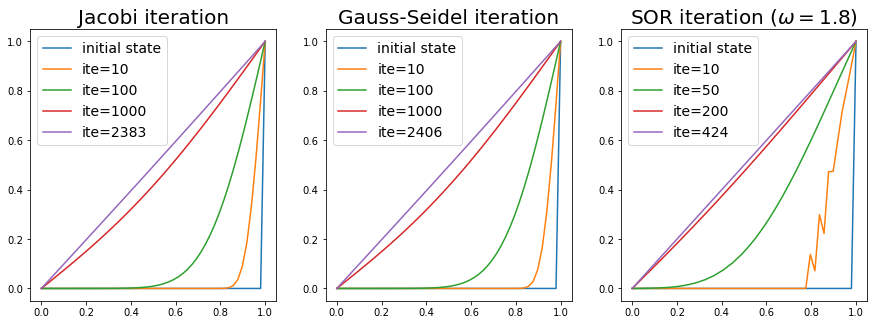

In [55]:
y_plot = np.linspace(0, 1, N)

plt.rcParams['figure.figsize'] = (15, 5)

fig1, ax1 = plt.subplots(1,3)

plot_j = [10, 100, 1000, 2383]
plot_g = [10, 100, 1000, 2406]
plot_sor = [10, 50, 200, 424]

ax1[0].plot(y_plot, c_store_J[0, 0, :], label='initial state')
ax1[1].plot(y_plot, c_store_g[0, 0, :], label='initial state')
ax1[2].plot(y_plot, c_store_s[0, 0, :], label='initial state')

for i in plot_j:
    ax1[0].plot(y_plot, c_store_J[i+1, 0, :], label='ite=%i' % i)
ax1[0].legend(fontsize=14)

for j in plot_g:
    ax1[1].plot(y_plot, c_store_g[j+1, 0, :], label='ite=%i' % j)
ax1[1].legend(fontsize=14)

for k in plot_sor:
    ax1[2].plot(y_plot, c_store_s[k+1, 0, :], label='ite=%i' % k)
ax1[2].legend(fontsize=14)

ax1[0].set_title('Jacobi iteration', fontsize=20)
ax1[1].set_title('Gauss-Seidel iteration', fontsize=20)
ax1[2].set_title(r'SOR iteration ($\omega=1.8$)', fontsize=20)

plt.show()

### Experiment SOR with different w

In [123]:
max_ite = 5000

delta_w = 0.05
w_value = np.linspace(1, 2, int(1/delta_w), endpoint=False)
delta_sw_store = np.zeros((len(w_value), max_ite+1))

if __name__ == '__main__':

    k_store = []

    for iteration, w in enumerate(w_value):
        c_store_w, delta_s_w, k = implement_sor(w=w)
        k_store.append(k)

        # Store the convergency measures for each w value
        delta_sw_store[iteration, :] = delta_s_w


### Convergency measure vs. iteration number

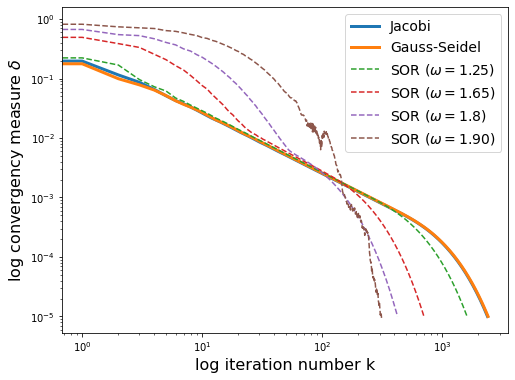

In [122]:
delta_j_p = delta_j[:2384]
delta_g_p = delta_g[:2407]
delta_s_p = delta_s[:425]

plt.rcParams['figure.figsize'] = (8, 6)

fig2, ax2 = plt.subplots(1)

x_label = 'log iteration number k'
y_label = r'log convergency measure $\delta$'

ax2.loglog(np.arange(2384), delta_j_p, label='Jacobi', lw=3)
ax2.loglog(np.arange(2407), delta_g_p, label='Gauss-Seidel', lw=3)
ax2.loglog(np.arange(1610), delta_sw_store[5, :1610], '--', label=r'SOR ($\omega=1.25$)')
ax2.loglog(np.arange(705), delta_sw_store[13, :705], '--', label=r'SOR ($\omega=1.65$)')
ax2.loglog(np.arange(425), delta_s_p, '--', label=r'SOR ($\omega=1.8$)')
ax2.loglog(np.arange(313), delta_sw_store[18, :313], '--', label=r'SOR ($\omega=1.90$)')

ax2.set(xlabel=x_label, ylabel=y_label)
ax2.xaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)

ax2.legend(fontsize=14, loc='upper right')

plt.show()


## Find the optimal w, using secant method

### Define optimizor

In [124]:
def optimize_sor(lower_bound=1.7, upper_bound=2, N=50, max_ite=5000, e=1e-5):
    a = lower_bound
    b = upper_bound
    check = 0
    
    for k in range(max_ite):

        # Calculate the midpoint
        c = (a + b) / 2

        convergency_l = implement_sor(max_ite=max_ite, w=a, e=e, N=N)

        # We dont really need the upper bound function value
        # Since we have prior knowledge of the interval we are studying

        # convergency_u = implement_sor(max_ite=max_ite, w=b, e=e, N=N)
        convergency_m = implement_sor(max_ite=max_ite, w=c, e=e, N=N)

        k_l = convergency_l[2]
        # k_u = convergency_u[2]
        k_m = convergency_m[2]

        # Apply the secant method
        if k_m < k_l:
            a = c
        if k_m > k_l:
            b = c

        # Check if midpoint and lower bound lie symmetriclly
        if k_m == k_l:
            check += 1
        if check == 2:
            print(convergency_m[2], '\n')
            break

        if k == max_ite-1:
            print('Failed to find the optimal solution in the max iteration steps!')
    
    return convergency_m[2], c

### Optimize with different N

In [93]:
N_value = np.linspace(10, 100, 10)
optimal_step = np.zeros(len(N_value))
optimal_w = np.zeros(len(N_value))

for i, n in enumerate(N_value):
    optimal = optimize_sor(N=int(n))
    optimal_w[i] = optimal[1]
    optimal_step[i] = optimal[0]

print(optimal_w, '\n', optimal_step)

89
107
189
220
272
332
453
438
504
544
[1.70029297 1.77503662 1.85014648 1.86992188 1.88808594 1.90654297
 1.92529297 1.92514648 1.93466797 1.93701172] 
 [ 89. 107. 189. 220. 272. 332. 453. 438. 504. 544.]


### Plot optimal w vs. N

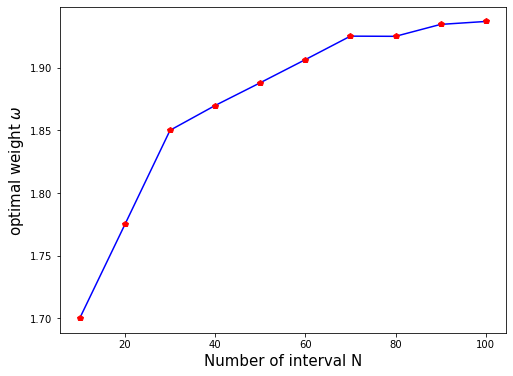

In [107]:
fig5, ax5 = plt.subplots(1)

plt.rcParams['figure.figsize'] = (8, 6)

ax5.plot(N_value, optimal_w, 'b')
ax5.plot(N_value, optimal_w, 'rp')
ax5.set(xlabel='Number of interval N', ylabel=r'optimal weight $\omega$')
ax5.xaxis.label.set_size(15)
ax5.yaxis.label.set_size(15)

plt.show()